In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import os 
from sklearn.utils import class_weight 

In [15]:
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32

In [47]:
# Set the paths to the training, test and validation data directories
train_dir = 'data/MSID_US_AUG_SP/train'
val_dir = 'data/MSID_US_AUG_SP/validation'

In [48]:
# Create an instance of the ImageDataGenerator class for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)

# Load the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)


Found 3311 images belonging to 4 classes.
Found 825 images belonging to 4 classes.
Found 248 images belonging to 4 classes.


In [19]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


# Add a global average pooling layer to reduce the spatial dimensions of the output of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with the number of units equal to the number of classes for the final prediction
predictions = Dense(num_classes, activation='softmax')(x)

# Create a new model with the input layer of the MobileNetV2 model and the output layer of the fully connected layer
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the MobileNetV2 model to prevent their weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

lr = 0.0003
optimizier = tf.keras.optimizers.Adam(learning_rate=lr)


# Compile the model
model.compile(optimizer=optimizier,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [21]:
history = model.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=val_generator)

Epoch 1/10
104/104 [==============================] - 39s 363ms/step - loss: 0.5958 - accuracy: 0.7804 - val_loss: 0.3702 - val_accuracy: 0.8679
Epoch 2/10
104/104 [==============================] - 37s 354ms/step - loss: 0.2602 - accuracy: 0.9136 - val_loss: 0.3131 - val_accuracy: 0.8994
Epoch 3/10
104/104 [==============================] - 37s 356ms/step - loss: 0.1738 - accuracy: 0.9508 - val_loss: 0.2125 - val_accuracy: 0.9333
Epoch 4/10
104/104 [==============================] - 37s 355ms/step - loss: 0.1292 - accuracy: 0.9683 - val_loss: 0.1941 - val_accuracy: 0.9430
Epoch 5/10
104/104 [==============================] - 37s 355ms/step - loss: 0.0952 - accuracy: 0.9783 - val_loss: 0.1925 - val_accuracy: 0.9455
Epoch 6/10
104/104 [==============================] - 37s 354ms/step - loss: 0.0792 - accuracy: 0.9831 - val_loss: 0.1892 - val_accuracy: 0.9455
Epoch 7/10
104/104 [==============================] - 37s 355ms/step - loss: 0.0663 - accuracy: 0.9888 - val_loss: 0.1907 - val_ac

In [27]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, batch_size=batch_size)
print('Test loss:', test_loss)

print('Test accuracy:', test_acc)

33/33 [==============================] - 9s 279ms/step - loss: 0.0991 - accuracy: 0.9643
Test loss: 0.09906256943941116
Test accuracy: 0.9642857313156128


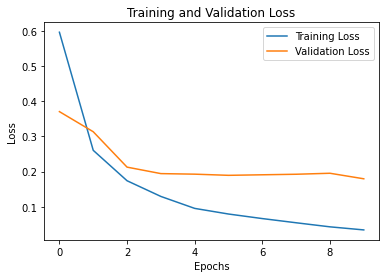

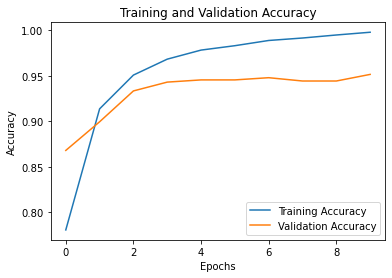

In [28]:
import matplotlib.pyplot as plt

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()


In [36]:
mobilemiracle = tf.keras.models.load_model('models/mobilemiracle.h5')

248/248 [==============================] - 3s 14ms/step


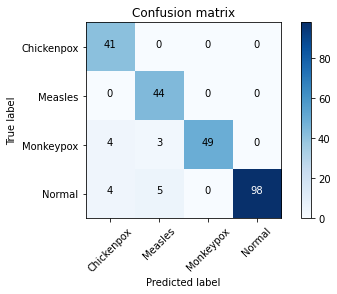

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

test_dir = 'data/MSID_SP/test'

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='categorical',
    shuffle= False
)

# Use the test generator to generate predictions
Y_pred = mobilemiracle.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define the class names
class_names = list(test_generator.class_indices.keys())

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='Confusion matrix')
plt.show()


In [31]:
# model.save('models/mobilemiracle.h5')

In [45]:
import cv2

# image = cv2.imread('data/MSID/Measles/measles1.png')

image = cv2.imread('chickenpox-test.jpeg')

# Resize the image to the input size expected by the model
input_size = (224, 224)  # example input size for a model
image = cv2.resize(image, input_size)

# Convert the image to a NumPy array
image = np.array(image)

# Scale the pixel values to be between 0 and 1
image = image / 255.0

# Add an extra dimension to the array to represent the batch size (1 in this case)
image = np.expand_dims(image, axis=0)

# assuming your preprocessed image is stored in a variable named 'preprocessed_image'
prediction = mobilemiracle.predict(image)

predicted_class = np.argmax(prediction)


print(predicted_class)

1/1 [==============================] - 0s 31ms/step
0
